In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import json
import regex as re
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.11.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def word_shape_features(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha(),word.isalnum(), word.isnumeric()])

def get_word_features(word):
    return word_shape_features(word)

def get_sent_features(sent):
    ret = []
    for word in sent:
        ret.append(get_word_features(word))
    return ret

In [3]:
TAGS =  pickle.load(open( "tags.pickle", "rb" ))
TAGS.remove("O") 
NUM_TAGS = len(TAGS)
# print(NUM_TAGS)

tag2id = {}
for id,label in enumerate(TAGS):
    tag2id[label] = id 

def label2id(labels):
    ret = []
    prev_label = ""
    for label in labels:
        if label == "O":
            ret.append([2*NUM_TAGS])
        elif label == prev_label:
            l =[tag2id[t]+ NUM_TAGS for t in label]
            ret.append(l)
        else:
            l =[tag2id[t] for t in label]
            ret.append(l)
        prev_label = label
    return ret 

In [4]:
def get_label(label_id):
    if label_id == (2*NUM_TAGS):
        return "O"
    elif label_id >= NUM_TAGS:
        return [TAGS[label_id-NUM_TAGS]]
    else:
        return TAGS[label_id]

def id2label(labels):
    ret = []
    for label in labels:
        l = [get_label(x) for x in label]
        if len(l) == 1 and l[0] == "O":
            l = "O"
        ret.append(l)
    return ret 

In [5]:
def clean_text(sent):
    '''
    This is text cleaning function
    '''
    ret_sent= []
    for txt in sent:
      fil_txt = re.sub('[^A-Za-z0-9]+', '', str(txt))
      if len(fil_txt) == 0:
        fil_txt  = txt [0]
      ret_sent.append(fil_txt)
    assert(len(ret_sent) == len(sent))
    return ret_sent

In [6]:
f = open('dev.json')
data = json.load(f)
f.close()

In [7]:
a = [d["sent"] for d in data]
set_ = set()
for idx,s in enumerate(a):
    for t in s:
        if len(t)<1:
            set_.add(idx)
data = [data[i] for i in range(len(data)) if i not in set_]

In [8]:
df = pd.DataFrame(data)
data_cp = data.copy()
df["sent"] = df["sent"].map( lambda x: clean_text(x))
df["features"] = df["sent"].map(lambda x: get_sent_features(x))
df["labels"] = df["tags"].map(lambda x: label2id(x))


In [9]:
sentences = list(df["sent"])
labels = list(df["labels"])
unique_word_set = set()
for x in sentences:
  for w in x:
    unique_word_set.add(w)
words_to_id = {}
for idx, w in enumerate(unique_word_set):
  words_to_id[w] = idx

num_words = len(unique_word_set)
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 9,956


In [28]:
def to_bool_vec(y_id):
    y_bool = np.zeros(2*NUM_TAGS+1, np.int32)
    num_labels = len(y_id)
    for id in y_id:
        # for l in label:
          y_bool[id] = 1
    return y_bool

In [29]:
from tensorflow.keras.utils import pad_sequences

max_len = 50

X = [[words_to_id[w] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

print(X.shape)

y_padding = np.zeros(2*NUM_TAGS+1, np.int32)
y_padding[2*NUM_TAGS] = 1

y = [[to_bool_vec(lbl) for lbl in l] for l in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=y_padding)

# y = [pad_sequences(maxlen=max_len, sequences=l, padding="post", value=NUM_TAGS*2) for l in labels]
# y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=[2*NUM_TAGS]*max_len)

print(y.shape)

(9956, 50)
(9956, 50, 227)


In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [33]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(2*NUM_TAGS+1, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            2109600   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 227)          45627     
 tributed)                                                       
                                                           

In [34]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

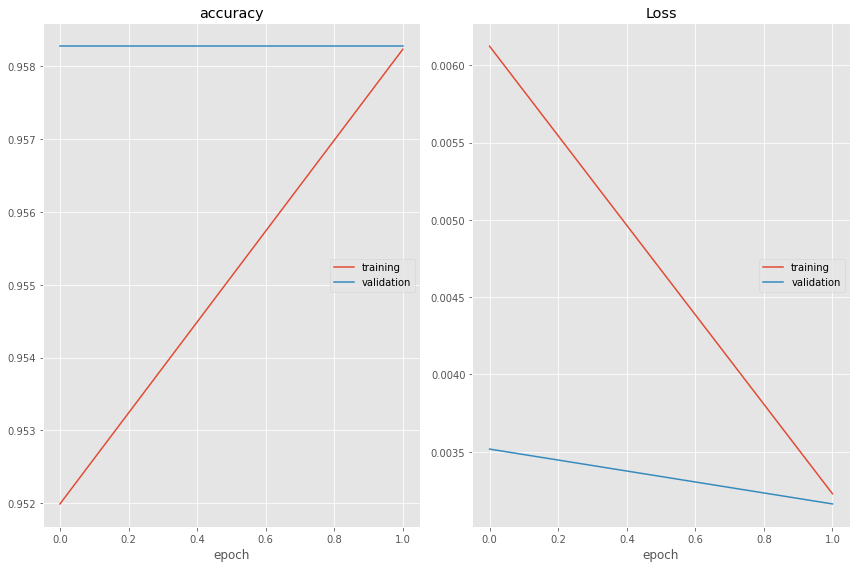

accuracy
	training         	 (min:    0.952, max:    0.958, cur:    0.958)
	validation       	 (min:    0.958, max:    0.958, cur:    0.958)
Loss
	training         	 (min:    0.003, max:    0.006, cur:    0.003)
	validation       	 (min:    0.003, max:    0.004, cur:    0.003)

Epoch 2: val_loss improved from 0.00352 to 0.00316, saving model to model_weights.h5
249/249 [==============================] - 103s 414ms/step - loss: 0.0032 - accuracy: 0.9582 - val_loss: 0.0032 - val_accuracy: 0.9583


In [36]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesKeras(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [37]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 2s 35ms/step - loss: 0.0032 - accuracy: 0.9583


[0.003162969136610627, 0.9582731127738953]